# Машинное обучение, ФКН ВШЭ

# Практическое задание 9. EM-алгоритм

## Общая информация

Дата выдачи: 18.02.2021

Мягкий дедлайн: 10.03.2022 23:59 MSK

Жёсткий дедлайн: 13.03.2022 23:59 MSK

## Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 15 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-09-em-Username.ipynb
* Модули preprocessing.py, metrics.py, models.py, содержащие написанный вами код
* Ссылки на посылки в Яндекс.Контест для всех функций и классов, которые вы реализовали

Ссылка на Яндекс.Контест: https://contest.yandex.ru/contest/35552

Username — ваша фамилия и имя на латинице именно в таком порядке

# Generative model of Labels, Abilities, and Difficulties (GLAD)

В [семинаре 15](https://github.com/esokolov/ml-course-hse/blob/master/2020-spring/seminars/sem15-em.pdf) мы рассмотрели задачу восстановления истинной разметки по меткам от экспертов (которым мы не можем доверять в полной мере, более того, их предсказания могут расходиться).

Рассмотрим следующую вероятностную модель:

$$ p(L, Z | \alpha, \beta) = \prod_{i=1}^{n} \prod_{j=1}^m \sigma(\alpha_j\beta_i)^{[l_{ij}=z_i]}\sigma(-\alpha_j\beta_i)^{1-[l_{ij}=z_i]} p(z_j)$$

где $l_{ij} -$ ответ $j$-го эксперта на задачу $i$, $z_j -$ истинная разметка, $\alpha_i, \beta_j-$ уровень экспертизы и сложность задачи соответственно. Для более подробного описания модели можно прочитать материалы семинара, а также [оригинальную статью](http://papers.nips.cc/paper/3644-whose-vote-should-count-more-optimal-integration-of-labels-from-labelers-of-unknown-expertise.pdf). Априорное распределение положим равномерным: $p(z_i) = 0.5$.

In [1]:
import numpy as np
seed = 0xDEADF00D
np.random.seed(seed)

In [10]:
L = np.load('L.npy')
n, m = L.shape

**Задание 1. (2 балла)** Реализуйте EM-алгоритм для заданной выше модели. Вы можете воспользоваться предложенными шаблонами или написать свои. 

Обратите внимание, что правдоподобие моделирует не вероятность метки $l_{ij}$ принять значение 1 или 0, а вероятность того, что она равна скрытой переменной $z_i$, т.е. $p(l_{ij} = z_j|z_j, \alpha_j, \beta_i) \neq p(l_{ij} = 1|\alpha_j, \beta_i) $. При этом заранее неизвестно, какая из скрытых переменных соответствует метке 1. Не забывайте, что параметры $\beta_i$ должны быть неотрицательными; для этого оптимизируйте $\log \beta$. На M-шаге можете использовать как один шаг градиентного спуска, так и несколько: разумные результаты у вас должны получаться вне зависимости от числа итераций.

Также при работе с вероятностями не забывайте о точности:
1. Используйте логарифмы вероятностей.
2. $\log \sigma(a)$ лучше преобразовать в $\log \sigma(a) = -\log(1 + \exp(-a)) = -\mathrm{softplus}(-a) $
3. Ещё полезные функции: `scipy.special.expit`, `scipy.special.logsumexp`, `np.log1p`

Для отладки может быть полезно проверить градиент с помощью `scipy.optimize.check_grad`.

In [11]:
def softplus(x):
    '''stable version of log(1 + exp(x))'''
    c = (x > 20) * 1.
    return np.log1p(np.exp(x * (1-c)) * (1-c)) + x * c

In [12]:
from scipy.special import expit

def posterior(alpha, beta, L):
    """ Posterior over true labels z p(z|l, alpha, beta)
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
    """
    beta_alpha = beta.reshape((-1, 1)) @ alpha.reshape((1, -1))
    gamma_0 = np.sum(np.where(L == 0, -softplus(-beta_alpha), -softplus(beta_alpha)), axis=1) - np.log(2)
    gamma_1 = np.sum(np.where(L == 1, -softplus(-beta_alpha), -softplus(beta_alpha)), axis=1) - np.log(2)
    q_0 = expit(gamma_0 - gamma_1)
    return np.vstack((q_0, 1 - q_0))


def alpha_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt alpha
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    beta_alpha = beta.reshape((-1, 1)) @ alpha.reshape((1, -1))
    summands = np.empty((2, *L.shape))
    summands[0] = q[0].reshape((-1, 1)) * np.where(L == 0, expit(-beta_alpha), -expit(beta_alpha))
    summands[1] = q[1].reshape((-1, 1)) * np.where(L == 1, expit(-beta_alpha), -expit(beta_alpha))
    return np.sum(summands * beta.reshape((1, -1, 1)), axis=(0, 1))


def logbeta_grad_lb(alpha, beta, L, q):
    """ Gradient of lower bound wrt logbeta
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    beta_alpha = beta.reshape((-1, 1)) @ alpha.reshape((1, -1))
    summands = np.empty((2, *L.shape))
    summands[0] = q[0].reshape((-1, 1)) * np.where(L == 0, expit(-beta_alpha), -expit(beta_alpha))
    summands[1] = q[1].reshape((-1, 1)) * np.where(L == 1, expit(-beta_alpha), -expit(beta_alpha))
    return np.sum(summands * alpha.reshape((1, 1, -1)) * beta.reshape((1, -1, 1)), axis=(0, 2))


def lower_bound(alpha, beta, L, q):
    """ Lower bound up to a constant
    Args:
        alpha: ndarray of shape (n_experts).
        beta: ndarray of shape (n_problems).
        L: ndarray of shape (n_problems, n_experts).
        q: ndarray of shape (2, n_problems).
    """
    beta_alpha = beta.reshape((-1, 1)) @ alpha.reshape((1, -1))
    summands = np.empty((2, *L.shape))
    summands[0] = q[0].reshape((-1, 1)) * np.where(L == 0, -softplus(-beta_alpha), -softplus(beta_alpha))
    summands[1] = q[1].reshape((-1, 1)) * np.where(L == 1, -softplus(-beta_alpha), -softplus(beta_alpha))
    return np.sum(summands)

In [7]:
from scipy.optimize import check_grad

alpha, logbeta = np.random.randn(m), np.random.randn(n)
beta = np.exp(logbeta)
q = np.ones((2, len(beta))) * 0.5

check_grad(
    lambda x: lower_bound(x, beta, L, q),
    lambda x: alpha_grad_lb(x, beta, L, q),
    x0=alpha)

0.0012134084221302715

In [8]:
check_grad(
    lambda x: lower_bound(alpha, np.exp(x), L, q),
    lambda x: logbeta_grad_lb(alpha, np.exp(x), L, q),
    x0=logbeta)

0.009290865171277944

In [9]:
def em(L, n_steps=1000, lr=1e-3):
    # initialize parameters
    alpha, logbeta = np.random.randn(m), np.random.randn(n)
    beta = np.exp(logbeta)
    q = np.ones((2, len(beta))) * 0.5

    for step in range(n_steps):
        # E-step
        q = posterior(alpha, beta, L)
        # M-step
        new_alpha = alpha + lr * alpha_grad_lb(alpha, beta, L, q)
        new_logbeta = logbeta + lr * logbeta_grad_lb(alpha, beta, L, q)
        alpha, logbeta = new_alpha, new_logbeta
        beta = np.exp(logbeta)

    return alpha, beta, q

In [10]:
alpha, beta, q = em(L)

**Задание 2. (1 балл)** Загрузите настоящую разметку. Посчитайте `accuracy` разметки, полученной с помощью обычного голосования по большинству среди экспертов, и сравните его с качеством, полученным с помощью EM-алгоритма. Помните, что алгоритму не важно, какая метка 0, а какая 1, поэтому если получите качество <0.5, то просто поменяйте метки классов (не забудьте также поменять знак у $\alpha$). 

In [11]:
y = np.load('y.npy')

maj_preds = np.median(L, axis=1)
print('Majority:', (maj_preds == y).mean())

em_preds = (q[1] > 0.5)
print('EM:', (em_preds == y).mean())

Majority: 0.8665
EM: 0.9555


**Задание 3. (0.5 балла)** Попробуйте проинтерпретировать полученные коэфициенты $\alpha$. Есть ли в выборке эксперты, которые намеренно голосуют неверно? Как это можно понять по альфам? Продемонстрируйте, что эксперты действительно чаще голосуют за неверный класс. Постройте график зависимости доли врено размеченных экспертом объектов от коэффициента $\alpha$. Прокомментируйте результаты.

In [12]:
np.random.seed(22022022)
smpl = np.random.choice(m, 10)
print('Random sample of alphas: ', *[f'{a:.3f}' for a in alpha[smpl]])
print('Corresponding accuracies:', *[(L[:, i] == y).mean() for i in smpl])

Random sample of alphas:  -4.206 0.573 0.540 0.540 4.146 0.677 -4.432 0.765 4.299 0.650
Corresponding accuracies: 0.088 0.681 0.679 0.679 0.9065 0.7015 0.082 0.709 0.911 0.697


*Даже по случайной микровыборке экспертов можно заметить, что маленькая $\alpha$ соответствует маленькой доле верных ответов, большая --- большому. И да, в выборке есть эксперты, качество которых значительно ниже $1/2$ (а $\alpha \ll 0$), что навевает мысли об их нечистоте. Найдём экспертов с самыми низкими альфами и посмотрим на их долю верных ответов:*

In [16]:
bad_guys = np.argsort(alpha)

i = 0
while alpha[bad_guys[i]] < 0:
    print(f'Alpha: {alpha[bad_guys[i]]:.3f}, accuracy: {(L[:, bad_guys[i]] == y).mean()}')
    i += 1

Alpha: -4.546, accuracy: 0.0825
Alpha: -4.432, accuracy: 0.082
Alpha: -4.284, accuracy: 0.0905
Alpha: -4.206, accuracy: 0.088


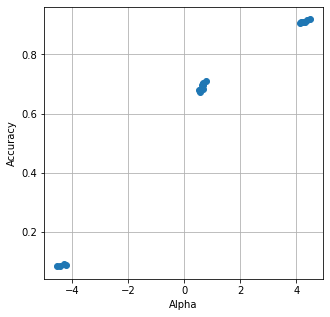

In [23]:
import matplotlib.pyplot as plt

plt.gcf().set_size_inches((5, 5))

plt.scatter(alpha, (L == y.reshape((-1, 1))).mean(axis=0))
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
_ = plt.grid()

*На последнем графике эксперты разделились на три кластера: вредины (левый нижний угол), умники (правый верхний угол) и просто честные люди (чуть выше середины). Нетрудно убедиться в том, что общая зависимость доли верных ответов от альфы монотонно возрастающая, но для более точного характера зависимости данных не хватает: уж больно разрозненные кластеры.*

**Задание 4. (бонус, 2 балла)**  Как уже было замечено выше, модели не важно, какой класс 1, а какой 0. Скажем, если все эксперты оказались максимально противными и ставят метку с точностью наоборот, то у вас будет полная согласованность между экспертами, при этом невозможно понять правильно они разметили выборку или нет, смотря только на такую разметку. Чтобы избежать этого, можно включать в выборку вопрос с заведомо известным ответом, тогда вы сможете определить, ставит ли эксперт специально неверные метки.

Чтобы обощить данную модель на случай заданий с заведомо известной меткой, достоточно не делать для них E-шаг, а всегда полагать апостериорное распределение вырожденным в истинном классе. Реализуйте данную модель и используйте истинную разметку *для нескольких* задач из обучения. Проинтерпретируйте полученные результаты.

# Выравнивание слов (Word Alignment)

In [2]:
# Moving all imports together
import glob
import matplotlib.pyplot as plt
import numpy as np
from unicodedata import normalize

from metrics import compute_aer
from preprocessing import extract_sentences, get_token_to_index, tokenize_sents, TokenizedSentencePair, SentencePair
from models import DiceAligner, WordAligner, WordPositionAligner

EM-алгоритм также применяют на практике для настройки параметров модели выравнивания слов, более сложные модификации которой используются в статистическом машинном переводе. Мы не будем подробно обсуждать применение word alignment для перевода и ограничимся следующей целью: пусть у нас есть параллельный корпус из предложений на исходном языке и их переводов на целевой язык (в этом задании используются английский и чешский соответственно). 

Первая задача — определить с помощью этого корпуса, как переводится каждое отдельное слово на целевом языке. Вторая задача — для произвольной пары из предложения и его перевода установить, переводом какого слова в исходном предложении является каждое слово в целевом предложении. Оказывается, у обеих задач существует элегантное и эффективное решение при введении правильной вероятностной модели: в этой части задания вам предстоит его реализовать и оценить результаты работы. Но обо всём по порядку :)

---

Перед тем, как заниматься машинным обучением, давайте разберёмся с данными и метриками в интересующей нас задаче. В ячейке ниже загружается и разархивируется параллельный английско-чешский корпус, в котором есть разметка выравнивания слов. Нетрудно заметить, что формат XML-файла, использованный его авторами, не вполне стандартный: нет готовой команды , которая позволила бы получить список пар предложений вместе с выравниваниями. Это значит, что нужно разобраться с форматом и написать парсер самостоятельно, используя встроенные средства Python, например, модуль [xml](https://docs.python.org/3.7/library/xml.html).

In [2]:
%%bash
wget -q https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-1804/CzEnAli_1.0.tar.gz -O CzEnAli_1.0.tar.gz
mkdir -p data
tar -xzf CzEnAli_1.0.tar.gz -C data/
head -n 20 data/merged_data/project_syndicate/project_syndicate_bacchetta1.wa

<?xml version="1.0" encoding="utf-8" ?>
<sentences>
<s id="project_syndicate_bacchetta1-s1">
  <english>Are the Dollar 's Days Numbered ?</english>
  <czech>Jsou dny dolaru sečteny ?</czech>
  <sure>1-1 3-3 5-2 6-4 7-5</sure>
  <possible>2-2 4-3</possible>
</s>
<s id="project_syndicate_bacchetta1-s2">
  <english>Philippe Bacchetta and Eric van Wincoop</english>
  <czech>Philippe Bacchetta and Eric van Wincoop</czech>
  <sure>1-1 2-2 3-3 4-4 5-5 6-6</sure>
  <possible></possible>
</s>
<s id="project_syndicate_bacchetta1-s3">
  <english>A year ago , the dollar bestrode the world like a colossus .</english>
  <czech>Ještě před rokem dolar dominoval světu jako imperátor .</czech>
  <sure>10-7 12-8 13-9 2-3 3-2 6-4 7-5 9-6</sure>
  <possible>1-3 11-8 3-1 5-4 8-6</possible>
</s>


**Задание -2. (0.5 балла)** Реализуйте функцию `extract_sentences`, которая принимает на вход путь к файлу с XML-разметкой, используемой в этом датасете, и возвращает список параллельных предложений, а также список из «уверенных» (sure) и «возможных» (possible) пар выравниваний. Отправьте вашу реализацию в Яндекс.Контест, чтобы убедиться в её корректности; в следующей ячейке ноутбука соберите все пары размеченных предложений из датасета в два списка `all_sentences` (список `SentencePair`) и `all_targets` (список LabeledAlignment).

Здесь и далее соблюдайте сигнатуры функций и пользуйтесь объявленными в модуле `preprocessing.py` классами для организации данных. Стоит заметить, что предложения уже токенизированы (даже отделена пунктуация), поэтому предобработку текстов совершать не нужно. Обратите внимание на формат хранения выравниваний: нумерация начинается с 1 (в таком виде и нужно сохранять), первым в паре идёт слово из англоязычного предложения.

In [3]:
all_sentences = []
all_targets = []

for filename in glob.glob('./data/merged_data/**/*'):
    sents, targets = extract_sentences(filename)
    all_sentences.extend(sents)
    all_targets.extend(targets)

len(all_sentences)

2501

**Задание -1. (0.5 балла)** Реализуйте функции `get_token_to_index` и `tokenize_sents` из модуля `preprocessing.py`, постройте словари token->index для обоих языков и постройте список из `TokenizedSentencePair` по выборке. Реализации функций также отправьте в Яндекс.Контест.

In [4]:
t_idx_src, t_idx_tgt = get_token_to_index(all_sentences)
tokenized_sentences = tokenize_sents(all_sentences, t_idx_src, t_idx_tgt)

В качестве бейзлайна для этой задачи мы возьмём способ выравнивания слов по коэффициенту Дайса: слово в исходном языке является переводом слова на целевом языке, если они часто встречаются в одних и тех же предложениях и редко встречаются по отдельности. 

Математически это записывается по аналогии с мерой Жаккара: пусть $c(x,y)$ — число параллельных предложений, в которых есть и $x$ (на исходном языке), и $y$ (на целевом языке), а $c(x)$ и $c(y)$ — суммарное количество предложений, в которых встречается слово $x$ и $y$ соответственно. Тогда $\textrm{Dice}(x,y)=\frac{2 \cdot c(x,y)}{c(x) + c(y)}$ — характеристика «похожести» слов $x$ и $y$. Она равна 1, если слова встречаются только в контексте друг друга (не бывает предложений только со словом $x$ без $y$ в переводе и наоборот), равна 0, если слова никогда не встречаются в параллельных предложениях и находится между пороговыми значениями в остальных случаях.

В файле `models.py` описан абстрактный класс `BaseAligner`, наследником которого должны являться все модели в задании, а также приведён пример реализации `DiceAligner` выравнивания слов описанным выше путём. Ниже вы можете увидеть, как применять эту модель.

In [4]:
baseline = DiceAligner(len(t_idx_src), len(t_idx_tgt), threshold=0.01)
baseline.fit(tokenized_sentences)

Чтобы оценить качество модели выравнивания, пользуясь имеющейся разметкой, существует ряд автоматических метрик. Они подразумевают, что в разметке есть два вида выравниваний — «уверенные» (sure) и «возможные» (possible). Обозначим для конкретного предложения первое множество выравниваний $S$, второе — $P$, а предсказанные выравнивания — $A$; причём, в отличие от разметки в файле, $S\subseteq P$. Тогда можно предложить три метрики, используя только операции над этими множествами:

Precision $=\frac{|A\cap P|}{|A|}$. Отражает, какая доля предсказанных нами выравниваний вообще корректна; если мы дадим в качестве ответа все возможные пары слов в предложении, эта метрика сильно просядет.

Recall $=\frac{|A\cap S|}{|S|}$. Эта метрика показывает, какую долю «уверенных» выравниваний мы обнаружили. Если мы попытаемся сделать слишком консервативную модель, которая выдаёт 0 или 1 предсказание на нетривиальных предложениях, полнота получится крайне низкая. 

Alignment Error Rate (AER) $=1-\frac{|A\cap P|+|A\cap S|}{|A|+|S|}$. Метрика является комбинацией двух предыдущих и отслеживает общее качество работы системы, штрафуя оба описанных выше вида нежелаемого поведения модели. 

**Задание 0. (0.5 балла)** Реализуйте функции compute_precision, compute_recall, compute_aer из модуля metrics.py. Оцените качество бейзлайнового метода. Обратите внимание, что нужно использовать микро-усреднение во всех функциях: необходимо просуммировать числитель и знаменатель по всем предложениям и только потом делить.

In [5]:
compute_aer(all_targets, baseline.align(tokenized_sentences))

0.8074618330841489

Теперь мы можем перейти к базовой вероятностной модели для выравнивания слов. Пусть $S=(s_1,\ldots,s_n)$ исходное предложение, $T=(t_1,\ldots,t_m)$ — его перевод. В роли латентных переменных будут выступать выравнивания $A=(a_1,\ldots,a_m)$ каждого слова в целевом предложении, причём $a_i\in\{1,\ldots,n\}$ (считаем, что каждое слово в $t$ является переводом какого-то слова из $s$). Параметрами модели является матрица условных вероятностей перевода: каждый её элемент $\theta(y|x)=p(y|x)$ отражает вероятность того, что переводом слова $x$ с исходного языка на целевой является слово $y$ (нормировка, соответственно, совершается по словарю целевого языка). Правдоподобие латентных переменных и предложения на целевом языке в этой модели записывается так:

$$
p(A,T|S)=\prod_{i=1}^m p(a_i)p(t_i|a_i,S)=\prod_{i=1}^m \frac{1}{n}\theta(t_i|s_{a_i}).
$$ 

**Задание 1. (2 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия ($\mathcal{L}$ в обозначениях лекции и семинара). **Обратите внимание, что на M-шаге нужно найти аналитический максимум по параметрам.**

*E-шаг для каждой пары предложений $(S_k, T_k)$ даёт нам свою матрицу вероятностей $Q_k$ размера $|S_k| \times |T_k|$. Посмотрим на её $(i, j)$-ый элемент:* $$ q_{kij} = p(a_j = i | t_j, S) = \frac{p(a_j = i, t_j | S)}{p(t_j | S)} = \frac{p(a_j = i) p(t_j|a_j = i, S)}{\sum_{l=1}^n p(a_j = l) p(t_j | a_j = l, S)} = \frac{\frac1n \theta(t_j | s_i)}{\sum_{l=1}^n \frac1n \theta(t_j | s_l)} = \frac{\theta(t_j | s_i)}{\sum_{s\in S_k} \theta(t_j | s)}. $$

*M-шаг для одной пары предложений $(S, T)$:* $$ \mathcal{L} = \mathbb E_{A \sim q} \log \frac{p(A, T| S)}{q(A)} = \mathbb E_{a_1 \sim q_{:,1}, \dots, a_m \sim q_{:, m}} \log \frac{p(A, T| S)}{q(A)} = $$
$$ = \sum_{i_1, \ldots, i_m = 1}^n \left( \prod_{j=1}^m p(a_j = i_j|t_j, S) \cdot \log \frac{\prod_{j=1}^m \frac1n \theta(t_j | s_{i_j})}{\prod_{j=1}^m p(a_j = i_j|t_j, S)} \right) = $$
<!-- $$ = \sum_{i_1, \ldots, i_m = 1}^n \left( \prod_{j=1}^m \frac{\theta(t_j | s_{i_j})}{\sum_{k=1}^n \theta(t_j | s_k)} \cdot \sum_{j=1}^m \log \frac{\frac1n \theta(t_j | s_{i_j})}{\frac{\theta(t_j | s_{i_j})}{\sum_{k=1}^n \theta(t_j | s_k)}} \right) = $$ -->
$$ = \sum_{i_1, \ldots, i_m = 1}^n \left( \prod_{j=1}^m p(a_j = i_j|t_j, S) \cdot \sum_{j=1}^m \log \frac{\theta(t_j | s_{i_j})}{n p(a_j = i_j|t_j, S)} \right) =  $$
$$ = \sum_{i_1, \ldots, i_m = 1}^n \sum_{k=1}^m \left( \log \frac{\theta(t_k | s_{i_k})}{n p(a_k = i_k|t_k, S)} \prod_{j=1}^m p(a_j = i_j|t_j, S) \right) = $$
$$ = \sum_{k=1}^m \left( \sum_{i_k = 1}^n p(a_k = i_k|t_k, S) \log \frac{\theta(t_k | s_{i_k})}{n p(a_k = i_k|t_k, S)} \sum_{i_1, \dots, i_{k-1}, i_{k+1}, \dots, i_m = 1}^n \prod_{\substack{j=1 \\ j \neq k}}^m p(a_j = i_j|t_j, S) \right) = $$
$$ = \sum_{k=1}^m \left( \sum_{i_k = 1}^n p(a_k = i_k|t_k, S) \log \frac{\theta(t_k | s_{i_k})}{n p(a_k = i_k|t_k, S)} \prod_{\substack{j=1 \\ j \neq k}}^m \underbrace{\sum_{i=1}^n p(a_j = i|t_j, S)}_{=1 \ \forall j} \right) = $$
$$ = \sum_{k=1}^m \left( \sum_{j = 1}^n p(a_k = j|t_k, S) \log \frac{\theta(t_k | s_j)}{n p(a_k = j|t_k, S)} \right) = $$
$$ = \sum_{k=1}^m \left( \sum_{j = 1}^n p(a_k = j|t_k, S) \log \theta(t_k | s_j) \right) - \sum_{k=1}^m \left( \sum_{j = 1}^n p(a_k = j|t_k, S) \log n \right) - \sum_{k=1}^m \left( \sum_{j = 1}^n p(a_k = j|t_k, S) \log p(a_k = j|t_k, S) \right) = $$
$$ = \sum_{k=1}^m \sum_{j = 1}^n q(a_k = j) \log \theta(t_k | s_j) - m \log n + H(q), $$
*значит, для всех предложений*
$$
\boxed{\mathcal L = \sum_{S_i, T_i} \left[ \sum_{k=1}^{|T_i|} \sum_{j = 1}^{|S_i|} q_{ijk} \log \theta(t_{ik} | s_{ij}) - |T_i| \log |S_i| - \sum_{k=1}^{|T_i|} \sum_{j = 1}^{|S_i|} q_{ijk} \log q_{ijk} \right]}
$$

*Осталось найти максимум. Пронумеруем все слова в словарях $D_S$ и $D_T$ &mdash; исходного и целевого языка соответственно &mdash; как $\{s_j\}_{j=1}^{|D_S|}$ и $\{t_k\}_{k=1}^{|D_T|}$  и попробуем продифференцировать ELBO:*
$$
\frac{\partial \mathcal L}{\partial \theta (t_k | s_j)} = \sum_{\{i | s_j \in S_i, \ t_k \in T_i\}} \frac{q_{ijk}}{\theta(t_k | s_j)}^*.
$$

*В такой постановке получается, что ноль производной не достигается вообще.
На самом же деле, не хватает естественного вероятностного ограничения: $\forall j \in \{1, \dots, |D_S|\} \ \sum_{k=1}^{|D_T|} \theta(t_k | s_j) = 1$.
Тогда лагранжиан задачи выглядит следующим образом:*
$$ L(\theta, \lambda) = \sum_{S_i, T_i} \left[ \sum_{k=1}^{|T_i|} \sum_{j = 1}^{|S_i|} q_{ijk} \log \theta(t_k | s_j) - |T_i| \log |S_i| - \sum_{k=1}^{|T_i|} \sum_{j = 1}^{|S_i|} q_{ijk} \log q_{ijk} \right] - \sum_{j = 1}^{|D_S|} \lambda_j \left(\sum_{k=1}^{|D_T|} \theta(t_k | s_j) - 1\right); $$
$$
\frac{\partial L}{\partial \theta (t_j | s_i)} = \sum_{\{i | s_j \in S_i, \ t_k \in T_i\}} \frac{q_{ijk}}{\theta(t_k | s_j)} - \lambda_j = 0 \implies \theta(t_k | s_j) = \sum_{\{i | s_j \in S_i, \ t_k \in T_i\}} \frac{q_{ijk}}{\lambda_j}
$$
$$
\sum_{l=1}^{|D_T|} \theta(t_l | s_j) = \frac1{\lambda_j} \sum_{l=1}^{|D_T|} \sum_{\{i | s_j \in S_i, \ t_l \in T_i\}} q_{ijl} = 1 \implies \boxed{\theta(t_k | s_j) = \frac{\sum_{\{i | s_j \in S_i, \ t_k \in T_i\}} q_{ijk}}{\sum_{l=1}^{|D_T|} \sum_{\{i | s_j \in S_i, \ t_l \in T_i\}} q_{ijl}}}
$$
*Отметим, что на практике пересчитывать $\theta$ можно следующим образом: вычислять только числители, а потом делить строки полученной матрицы на соответствующие суммы.*

--------
**В тех случаях, когда одна пара токенов встречается в одном предложении дважды, соответствующее слагаемое так же должно быть учтено дважды. Поэтому, формально говоря, суммирование производится не по множеству пар предложений $\{(S_i, T_i)\}$, а по множеству пар токенов $\{(s', t') | s' = s_j, \ t' = t_k\}$. При реализации учтём это, а в теоретических выкладках опустим.*

**Задание 2. (2.5 балла)** Реализуйте все методы класса `WordAligner` в соответствии с полученными вами формулами. Протестируйте вашу реализацию через Яндекс.Контест, а здесь обучите модель и посчитайте её AER на истинной разметке. Чтобы предсказать выравнивание для пары предложений в этой модели, следует выбирать в соответствие для слова в целевом предложении с индексом $i$ позицию, соответствующую максимуму апостериорного распределения $p(a_i|T,S)$.

In [5]:
word_aligner = WordAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_aligner.fit(tokenized_sentences)
compute_aer(all_targets, word_aligner.align(tokenized_sentences))

/home/esquerte/Downloads/homeworks/mlhw9/models.py:113: RuntimeWarning: divide by zero encountered in log
  result += np.sum((np.log(self.translation_probs[ixgrid]) - np.log(posterior, where=lambda x: x != 0)) * posterior) - m * np.log(n)
/home/esquerte/Downloads/homeworks/mlhw9/models.py:113: RuntimeWarning: invalid value encountered in subtract
  result += np.sum((np.log(self.translation_probs[ixgrid]) - np.log(posterior, where=lambda x: x != 0)) * posterior) - m * np.log(n)


0.5747172568511829

Заметим, что таблицу вероятностей перевода можно использовать и саму по себе для построения словарей. Пример работы показан ниже: метод хоть и работает, но мягко говоря, неидально — слишком мало данных.

In [6]:
idx_token_tgt = {index:token for token, index in t_idx_tgt.items()}

In [7]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mr']].argsort()[-3:]]

['Pan', 'řekl', 'pan']

In [8]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['Mrs']].argsort()[-3:]]

['-', 'Mannová', 'paní']

In [9]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['water']].argsort()[-3:]]

['z', 'pro', 'vody']

In [10]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['depended']].argsort()[-3:]]

['záviselo', 'dne', 'překupničením']

In [11]:
[idx_token_tgt[i] for i in word_aligner.translation_probs[t_idx_src['on']].argsort()[-3:]]

['.', 'se', 'na']

**Задание 3. (0.5 балла)** Мы смогли получить матрицу условных вероятностей перевода исходного языка в целевой. Можно ли, пользуясь этой матрицей и ещё какими-то статистиками по параллельному корпусу, получить вероятности перевода целевого языка в исходный? Реализуйте такой метод и приведите ниже пример его работы, показав пару удачных переводов.

In [16]:
# Попробуем сделать самую напрашивающуюся вещь: транспонируем таблицу и отнормируем по строкам
# (впрочем, для сортировки даже нормировать не обязательно).
# Этот подход уже достаточно стабильно работает
reverse_translation_probs = word_aligner.translation_probs.T / word_aligner.translation_probs.sum(axis=0).reshape((-1, 1))

In [13]:
idx_token_src = {index: token for token, index in t_idx_src.items()}

In [18]:
[idx_token_src[i] for i in reverse_translation_probs[t_idx_tgt['pan']].argsort()[-3:]]

['organist', 'choirmaster', 'Mr']

In [19]:
[idx_token_src[i] for i in reverse_translation_probs[t_idx_tgt['na']].argsort()[-3:]]

['East', 'response', 'on']

In [21]:
[idx_token_src[i] for i in reverse_translation_probs[t_idx_tgt['jako']].argsort()[-3:]]

['Like', 'as', 'like']

**Задание 4. (0.5 балла)** Визуализируйте полученные выравнивания для нескольких предложений в виде heatmap: по одной из осей располагаются токены исходного текста, по другой — токены его перевода, на пересечении позиций $i$ и $j$ — 0 либо 1 в зависимости от того, является ли в обученной модели $a_i$ равным $j$. Можете ли вы их проинтерпретировать? Постройте аналогичный график, но без дискретизации, а визуализируя напрямую апостериорное распределение. Можете ли вы найти ситуации, в которых модель не уверена, переводом какого слова является слово $i$?

In [49]:
def visualize_binary(pair: TokenizedSentencePair):
    m, n = len(pair.target_tokens), len(pair.source_tokens)
    plt.gcf().set_size_inches((m / 3, n / 3))
    alignment = word_aligner.align([pair])[0]
    table = np.array([[(1 if (j + 1, i + 1) in alignment else 0) for i in range(m)] for j in range(n)])
    plt.imshow(table)
    plt.xticks(np.arange(m), labels=[idx_token_tgt[i] for i in pair.target_tokens], rotation=60, ha="right", rotation_mode="anchor")
    plt.yticks(np.arange(n), labels=[idx_token_src[i] for i in pair.source_tokens])
    for i in range(m):
        for j in range(n):
            plt.text(i, j, table[j, i], ha="center", va="center")

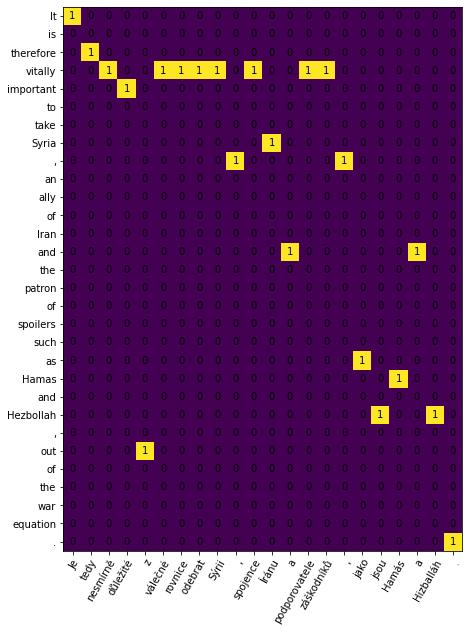

In [54]:
visualize_binary(tokenized_sentences[2])

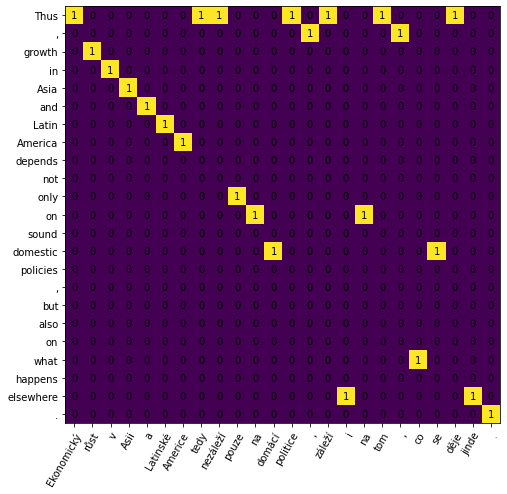

In [73]:
visualize_binary(tokenized_sentences[24])

*Какие выводы можно сделать по полученным изображениям? Наряду с хорошим переводом, заметны случаи, когда модель назначает целой пачке слов один и тот же исходный токен ("vitally" в первом случае и "Thus" во втором). Видимо, такие результаты соответствуют неуверенности модели. Также стоит отметить, что если в одном исходном предложении встречаются несколько одинаковых токенов (например, запятых), то в выравнивании участвует всегда первый из них. Нехорошо.*

In [69]:
def visualize_probs(pair: TokenizedSentencePair):
    m, n = len(pair.target_tokens), len(pair.source_tokens)
    plt.gcf().set_size_inches((m * 0.42, n * 0.42))
    table = word_aligner.translation_probs[np.ix_(pair.source_tokens, pair.target_tokens)]
    plt.imshow(table)
    plt.xticks(np.arange(m), labels=[idx_token_tgt[i] for i in pair.target_tokens], rotation=60, ha="right", rotation_mode="anchor")
    plt.yticks(np.arange(n), labels=[idx_token_src[i] for i in pair.source_tokens])
    for i in range(m):
        for j in range(n):
            plt.text(i, j, f'{table[j, i]:.2f}', ha="center", va="center")

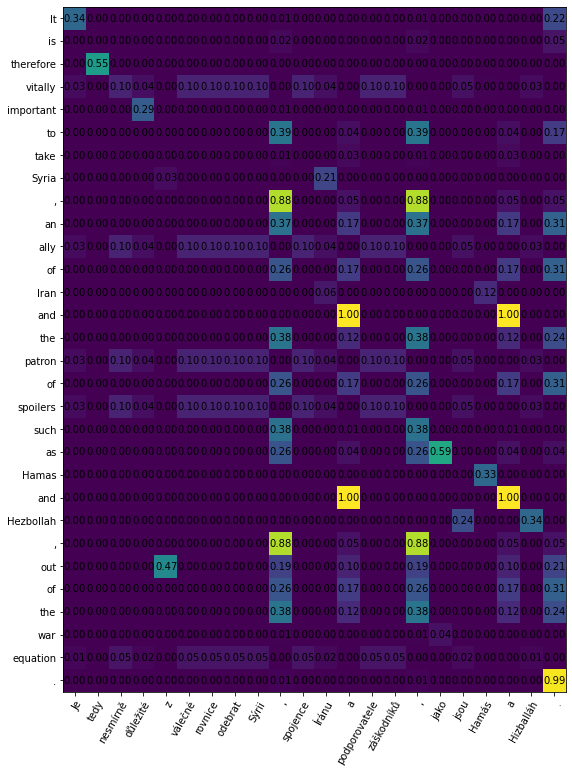

In [70]:
visualize_probs(tokenized_sentences[2])

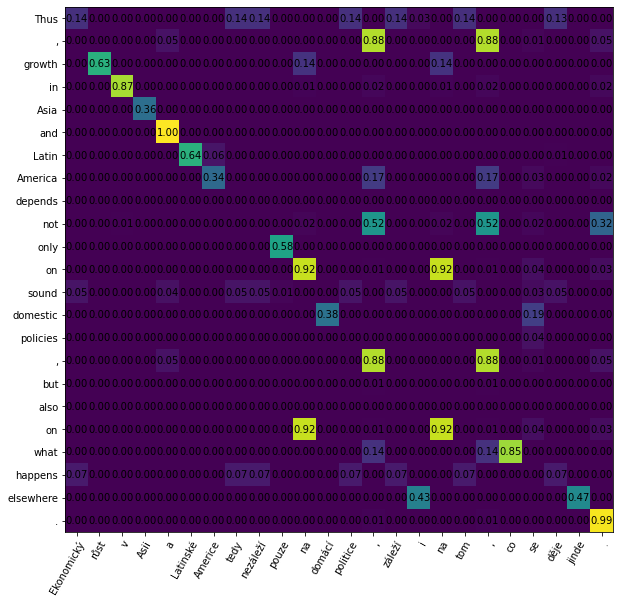

In [74]:
visualize_probs(tokenized_sentences[24])

*Наше предположение из прошлой ремарки скорее подтвердилось: когда модель не уверена, у нас есть несколько вариантов с очень похожими, но маленькими вероятностями, и в выравнивание попадает первый из вариантов, независимо от положения целевого токена в предложении.*

Заметим, что при задании модели мы сделали довольно сильное предположение о том, что вероятности выбора слова для выравнивания никак не зависят от позиции слова в целевом предложении. Можно сделать эти вероятности настраиваемыми параметрами, получив прямоугольную матрицу $\phi_{m,n}(j|i)=p(a_i=j|m,n)$ для каждой пары длин предложений $m,n$: по-прежнему мы получаем распределение над индексами в исходном предложении. Тогда модель приобретает вид
$$
p(A,T|S)=\prod_{i=1}^m p(a_i|m,n)p(t_i| a_i, S)=\prod_{i=1}^m \phi_{m,n}(a_i|i)\theta(t_i|s_{a_i}).
$$

**Задание 5. (1.5 балла)** Выведите шаги EM-алгоритма для этой модели, а также получите выражение для подсчёта нижней оценки правдоподобия.

*E-шаг для каждой пары предложений $(S_k, T_k)$ даёт нам свою матрицу вероятностей $Q_k$ размера $|S_k| \times |T_k|$. Посмотрим на её $(i, j)$-ый элемент:* $$ q_{kij} = p(a_{kj} = i | t_{kj}, m_k, n_k, S) = \frac{p(a_{kj} = i, t_{kj} | m_k, n_k, S)}{p(t_{kj} | m_k, n_k, S)} = \frac{p(a_{kj} = i | m_k, n_k) p(t_{kj}|a_{kj} = i, S)}{\sum_{l=1}^n p(a_{kj} = l | m_k, n_k) p(t_{kj} | a_{kj} = l, S)} = \frac{\phi_{m_k,n_k}(i|j) \theta(t_{kj} | s_{ki})}{\sum_{l=1}^n \phi_{m_k,n_k}(l|j) \theta(t_{kj} | s_{kl})}. $$

*M-шаг для одной пары предложений $(S, T)$ (индекс $k$ опускаем):* $$ \mathcal{L} = \mathbb E_{A \sim q} \log \frac{p(A, T| S)}{q(A)} = \mathbb E_{a_1 \sim q_{:,1}, \dots, a_m \sim q_{:, m}} \log \frac{p(A, T| S)}{q(A)} = $$
$$ = \sum_{i_1, \ldots, i_m = 1}^n \left( \prod_{j=1}^m p(a_j = i_j|t_j, m, n, S) \cdot \log \frac{\prod_{j=1}^m \phi_{m,n}(i_j|j) \theta(t_j | s_{i_j})}{\prod_{j=1}^m p(a_j = i_j|t_j, m, n, S)} \right) = $$
$$ = \sum_{i_1, \ldots, i_m = 1}^n \left( \prod_{j=1}^m p(a_j = i_j|t_j, m, n, S) \cdot \sum_{j=1}^m \log \frac{\phi_{m,n}(i_j|j) \theta(t_j | s_{i_j})}{p(a_j = i_j|t_j, m, n, S)} \right) =  $$
$$ = \sum_{i_1, \ldots, i_m = 1}^n \sum_{k=1}^m \left( \log \frac{\phi_{m,n}(i_k|k) \theta(t_k | s_{i_k})}{p(a_k = i_k|t_k, m, n, S)} \prod_{j=1}^m p(a_j = i_j|t_j, m, n, S) \right) = $$
$$ = \sum_{k=1}^m \left( \sum_{i_k = 1}^n p(a_k = i_k|t_k, m, n, S) \log \frac{\phi_{m,n}(i_k|k) \theta(t_k | s_{i_k})}{p(a_k = i_k|t_k, m, n, S)} \sum_{i_1, \dots, i_{k-1}, i_{k+1}, \dots, i_m = 1}^n \prod_{\substack{j=1 \\ j \neq k}}^m p(a_j = i_j|t_j, m, n, S) \right) = $$
$$ = \sum_{k=1}^m \left( \sum_{i_k = 1}^n p(a_k = i_k|t_k, m, n, S) \log \frac{\phi_{m,n}(i_k|k) \theta(t_k | s_{i_k})}{p(a_k = i_k|t_k, m, n, S)} \prod_{\substack{j=1 \\ j \neq k}}^m \underbrace{\sum_{i=1}^n p(a_j = i|t_j, m, n, S)}_{=1 \ \forall j} \right) = $$
$$ = \sum_{k=1}^m \left( \sum_{j = 1}^n p(a_k = j|t_k, m, n, S) \log \frac{\phi_{m,n}(j|k) \theta(t_k | s_j)}{p(a_k = j|t_k, m, n, S)} \right) = $$
$$ = \sum_{k=1}^m \left( \sum_{j = 1}^n p(a_k = j|t_k, m, n, S) (\log \theta(t_k | s_j) + \log \phi_{m,n}(j|k)) \right) - \sum_{k=1}^m \left( \sum_{j = 1}^n p(a_k = j|t_k, m, n, S) \log p(a_k = j|t_k, m, n, S) \right) = $$
$$ = \sum_{k=1}^m \sum_{j = 1}^n q(a_k = j) (\log \theta(t_k | s_j) + \log \phi_{m,n}(j|k)) + H(q), $$
*значит, для всех предложений*
$$
\boxed{\mathcal L = \sum_{i = 1}^{P} \left[ \sum_{k=1}^{|T_i|} \sum_{j = 1}^{|S_i|} q_{ijk} (\log \theta(t_{ik} | s_{ij}) + \log \phi_{m_i,n_i}(j|k)) - \sum_{k=1}^{|T_i|} \sum_{j = 1}^{|S_i|} q_{ijk} \log q_{ijk} \right],}
$$
*где $P$ &mdash; количество пар предложений.* 

*Добавим ограничения: $\forall j \in \{1, \dots, |D_S|\} \ \sum_{k=1}^{|D_T|} \theta(t_k | s_j) = 1$, $\forall i \in \{1, \dots, P\} \ \forall k \in \{1, \dots, |T_i|\} \sum_{j=1}^{|S_i|} \phi_{m_i, n_i}(j|k) = 1$.
Тогда лагранжиан задачи выглядит следующим образом:*
$$ L(\theta, \lambda, \mu) = \sum_{i = 1}^{P} \left[ \sum_{k=1}^{|T_i|} \sum_{j = 1}^{|S_i|} q_{ijk} (\log \theta(t_{ik} | s_{ij}) + \log \phi_{m_i,n_i}(j|k)) - H(q) \right] - \sum_{j = 1}^{|D_S|} \lambda_j \left(\sum_{k=1}^{|D_T|} \theta(t_k | s_j) - 1\right) - \sum_{i = 1}^{P} \sum_{k = 1}^{|T_i|} \mu_{ik} \left(\sum_{j=1}^{|S_i|} \phi_{m_i, n_i}(j|k) - 1\right). $$

*Продифференцируем сначала по $\theta$:*
$$
\frac{\partial L}{\partial \theta (t_j | s_i)} = \sum_{\{i | s_j \in S_i, \ t_k \in T_i\}} \frac{q_{ijk}}{\theta(t_k | s_j)} - \lambda_j = 0 \implies \theta(t_k | s_j) = \sum_{\{i | s_j \in S_i, \ t_k \in T_i\}} \frac{q_{ijk}}{\lambda_j}^*
$$
$$
\sum_{l=1}^{|D_T|} \theta(t_l | s_j) = \frac1{\lambda_j} \sum_{l=1}^{|D_T|} \sum_{\{i | s_j \in S_i, \ t_l \in T_i\}} q_{ijl} = 1 \implies \boxed{\theta(t_k | s_j) = \frac{\sum_{\{i | s_j \in S_i, \ t_k \in T_i\}} q_{ijk}}{\sum_{l=1}^{|D_T|} \sum_{\{i | s_j \in S_i, \ t_l \in T_i\}} q_{ijl}}}
$$
*Теперь по $\phi$:*
$$
\frac{\partial L}{\partial \phi_{m,n} (j|k)} = \sum_{\{i | |S_i| = n, \ |T_i| = m\}} \frac{q_{ijk}}{\phi_{m,n} (j|k)} - \mu_{ik} = 0 \implies \phi_{m,n} (j|k) = \sum_{\{i | |S_i| = n, \ |T_i| = m\}} \frac{q_{ijk}}{\mu_{ik}}
$$
$$
\sum_{l=1}^{n} \phi_{m,n} (l|k) = \frac1{\mu_{ik}} \sum_{l=1}^{n} \sum_{\{i | |S_i| = n, \ |T_i| = m\}} q_{ilk} = 1 \implies \boxed{\phi_{m,n} (j|k) = \frac{\sum_{\{i | |S_i| = n, \ |T_i| = m\}} q_{ijk}}{\sum_{l=1}^{n} \sum_{\{i | |S_i| = n, \ |T_i| = m\}} q_{ilk}}}
$$

*Отметим, что на практике пересчитывать $\theta$ и $\phi$ можно следующим образом: вычислять только числители, а потом делить строки (столбцы) полученной матрицы на соответствующие суммы.*

--------
**Опять же, помним про возможные повторы пар.*

**Задание 6. (2 балла)** Реализуйте все методы класса `WordPositionAligner`, протестируйте их корректность через Яндекс.Контест. Обучите модель, оцените её качество на истинной разметке и сравните его с качеством предыдущей более простой модели. Проиллюстрируйте влияние стартовых параметров на результат, проинициализировав эту модель параметрами модели из задания 2 (важно, чтобы суммарное число эпох обучения в обоих сценариях оставалось тем же).

In [5]:
word_pos_aligner = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 20)
word_pos_aligner.fit(tokenized_sentences)
compute_aer(all_targets, word_pos_aligner.align(tokenized_sentences))

0.5912238996429049

In [6]:
word_aligner_for_pretrain = WordAligner(len(t_idx_src), len(t_idx_tgt), 5)
word_aligner_for_pretrain.fit(tokenized_sentences)

word_pos_aligner_with_pretrain = WordPositionAligner(len(t_idx_src), len(t_idx_tgt), 15)
word_pos_aligner_with_pretrain.translation_probs = word_aligner_for_pretrain.translation_probs
word_pos_aligner_with_pretrain.fit(tokenized_sentences)
compute_aer(all_targets, word_pos_aligner_with_pretrain.align(tokenized_sentences))

0.5603511263416793

**Задание 7. (1 балл)** В предыдущих пунктах мы никак не заостряли внимание на предобработке текстов, что может негативно влиять на результаты обученной модели. Например, сейчас метод выравнивания учитывает регистр, а слова на чешском языке вдобавок обладают богатой морфологией и большим количеством диакритических знаков. Если сократить количество параметров модели (различных слов), можно ускорить обучение и добиться лучших результатов, потому что статистики по словам будут считаться по большему числу параллельных предложений.

Примените к исходным данным [Unicode-нормализацию](https://en.wikipedia.org/wiki/Unicode_equivalence#Normalization), приведите их к нижнему регистру и обучите модель выравнивания заново. Сравните качество и скорость обучения с предыдущими результатами и сделайте выводы. Если вы найдете в данных ещё какие-то проблемы, которые можно исправить более грамотной предобработкой, также продемонстрируйте, как их решение влияет на качество.

**Важно:** здесь и далее в процессе обработки данных у вас может получаться, что из тестовых данных будут удалены предложения из-за отсутствия слов в словаре. Если такое всё же произошло, для корректности сравнения считайте AER вашей модели на удалённых предложениях равным 1.

In [8]:
new_sentences = []
for pair in all_sentences:
    new_pair = SentencePair(source=[normalize('NFC', token).lower() for token in pair.source],
                            target=[normalize('NFC', token).lower() for token in pair.target])
    new_sentences.append(new_pair)

t_idx_src_new, t_idx_tgt_new = get_token_to_index(new_sentences)
tokenized_sentences_new = tokenize_sents(new_sentences, t_idx_src_new, t_idx_tgt_new)

In [10]:
# Clean WordAligner applied to newly preprocessed data
word_aligner_new = WordAligner(len(t_idx_src_new), len(t_idx_tgt_new), 20)
word_aligner_new.fit(tokenized_sentences_new)
compute_aer(all_targets, word_aligner_new.align(tokenized_sentences_new))

/home/esquerte/Downloads/homeworks/mlhw9/models.py:114: RuntimeWarning: divide by zero encountered in log
  result += np.sum((np.log(self.translation_probs[ixgrid]) - np.log(posterior)) * posterior) - m * np.log(n)
/home/esquerte/Downloads/homeworks/mlhw9/models.py:114: RuntimeWarning: invalid value encountered in subtract
  result += np.sum((np.log(self.translation_probs[ixgrid]) - np.log(posterior)) * posterior) - m * np.log(n)


0.5601864715507394

In [9]:
# Several iterations of WordAligner + other with WordPositionAligner
word_aligner_for_pretrain_new = WordAligner(len(t_idx_src_new), len(t_idx_tgt_new), 5)
word_aligner_for_pretrain_new.fit(tokenized_sentences_new)

word_pos_aligner_with_pretrain_new = WordPositionAligner(len(t_idx_src_new), len(t_idx_tgt_new), 15)
word_pos_aligner_with_pretrain_new.translation_probs = word_aligner_for_pretrain_new.translation_probs
word_pos_aligner_with_pretrain_new.fit(tokenized_sentences_new)
compute_aer(all_targets, word_pos_aligner_with_pretrain_new.align(tokenized_sentences_new))

0.5483519084519363

*Для обеих техник качество выросло: для чистого WordAligner'а AER упал на 0.015, для последовательности моделей &mdash; примерно на 0.012. Что касается скорости, то в первом случае она почти не изменилась, а во втором время вычислений сократилось на пару секунд. Таким образом, новая предобработка явно помогла.*

**Задание 7. (бонус, до 3 баллов)** 

Улучшите качество получившейся системы настолько, насколько сможете. За каждые 5 процентов, на которые AER на тех же данных получается меньше, чем минимум ошибки всех предыдущих моделей, вы получите по 1 бонусному баллу.

Ниже приведены несколько идей, которые могут помочь вам повысить 

* Модифицировать модель: как вы можете понять, недостатком второго реализованного вами подхода является избыточное число параметров из-за необходимости подерживать отдельную матрицу для каждой различной пары длин предложений в корпусе. В статье https://www.aclweb.org/anthology/N13-1073.pdf приведён способ снижения числа параметров, задающих априорное распределение позиций выравнивания, который позволяет в десять раз быстрее обучать модель и получать лучшее качество.
* Агрегация по двум направлениям: в статье https://www.aclweb.org/anthology/J03-1002/ утверждается, что асимметричность выравниваний вредит качеству, потому что из-за выбранной модели одному слову в целевом предложении не может соответствовать два слова в исходном предложении. Для решения этой проблемы (и улучшения метрик, разумеется) авторы предлагают несколько алгоритмов, которые можно попробовать применить в этом задании.
* Использовать больше обучающих данных. В корпусе, которым мы пользуемся, только пара тысяч предложений, чего может не хватать для по-настоящему хорошей модели выравнивания. Разумеется, неразмеченных параллельных английско-чешских корпусов гораздо больше, поэтому можно воспользоваться ими. Хорошая точка для старта — данные с соревнования по машинному переводу  [воркшопа WMT](http://www.statmt.org/wmt20/translation-task.html).
* В языках часто существуют слова наподобие артиклей или предлогов, которым не соответствует ни одно слово в переводе. Все рассмотренные в рамках задания модели это не учитывают, возможно, добавление возможности перевода в «нулевой» токен улучшит качество модели (при тестировании такие выравнивания имеет смысл выбрасывать)

In [ ]:
# ┐_(ツ)_┌━☆ﾟ.*･｡ﾟ